In [9]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt


from scipy.sparse import lil_matrix
from collections import defaultdict
import operator
import math
%matplotlib inline

In [10]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tobia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
people = pd.read_csv('10k-people-raw.csv', sep=';')

In [4]:
vip = []
print('Name\t\t\t', 'Index')
for index, name in enumerate(people['Name']):
    if name == 'Michael Schumacher':
        vip.append((index, 'Michael Schumacher'))
        print('Michael Schumacher:\t', index)
    if name == 'Albert Einstein':
        vip.append((index, 'Albert Einstein'))
        print('Albert Einstein:\t', index)
    if name == 'Michael Jackson':
        vip.append((index, 'Michael Jackson'))
        print('Michael Jackson:\t', index)

Name			 Index
Michael Schumacher:	 3
Albert Einstein:	 215
Michael Jackson:	 1951


In [5]:
print(vip)

[(3, 'Michael Schumacher'), (215, 'Albert Einstein'), (1951, 'Michael Jackson')]


In [6]:
print(people['text'][3][:600])
print()
print(people['text'][215][:600])
print()
print(people['text'][1951][:600])

Vorlage:Infobox Formel-1-Fahrer/Wartung/Alte Parameter Michael Schumacher (* 3. Januar 1969 in Hürth-Hermülheim, Nordrhein-Westfalen) ist ein ehemaliger deutscher Automobilrennfahrer. Schumacher startete von 1991 bis 2006 sowie von 2010 bis 2012 zu insgesamt 307 Großen Preisen der Formel-1-Weltmeisterschaft. Mit sieben Weltmeistertiteln, 91 Siegen, 68 Pole-Positions und 77 schnellsten Rennrunden ist er der erfolgreichste Pilot der Formel-1-Geschichte. Darüber hinaus stand er mit 155 Platzierungen unter den Top drei am häufigsten auf dem Siegerpodest. Nachdem Schumacher 1990 und 1991 in der Spo

Albert Einstein (* 14. März 1879 in Ulm; † 18. April 1955 in Princeton, New Jersey) war ein theoretischer Physiker. Seine Forschungen zur Struktur von Materie, Raum und Zeit sowie dem Wesen der Gravitation veränderten maßgeblich das physikalische Weltbild. Er gilt daher als einer der bedeutendsten Physiker aller Zeiten. Einsteins Hauptwerk, die Relativitätstheorie, machte ihn weltberühmt. Im Jah

In [12]:
import nltk
stem = nltk.stem.snowball.SnowballStemmer('german')

In [8]:
text = people['text'][1951][:600]
stemmed_text_example = []
stemmed_text_example.append(' '.join([stem.stem(word.lower()) for word in nltk.word_tokenize(str(text.encode('utf8')))
                              if word.isalpha() ]))

In [9]:
stemmed_text_example

['joseph jackson august in gary indiana juni in los angel kaliforni war ein komponist und entertain aufgrund sein erfolg wird er als of bezeichnet jackson gilt mit weltweit etwa bis million verkauft laut der rekord als erfolgreich entertain all zeit and quell geb sogar bis zu million abgesetzt platt an postum verkauft sich innerhalb ein jahr nach sein tod weit million sein alb jackson wurd bereit als kind teil der in d']

####  Vielleicht wollen Sie das Pre-Processing etwas verbessern um Umlaut  (ä --> ae, ... ), Wort-Verbindungen (US-amerikanisch, Guinness-Buch, ... ) etc.  zu "retten"

# 1) Zipf law

In [37]:
word_dict = defaultdict(int)
word_count = 0
word_index = {}

i = 0
for text in people['text']:
    for word in nltk.word_tokenize(str(text.encode('utf8'))):
        if not word.isalpha(): continue
        w = stem.stem(word.lower())
        word_dict[w] += 1
        word_count += 1
        if w not in word_index:
            word_index[w] = i
            i += 1

In [38]:
rel_dict = defaultdict(float)
rank = []

for key, value in sorted(word_dict.items(), key=operator.itemgetter(1), reverse=True):
    rel_dict[key] = value / word_count
    rank.append(rel_dict[key])

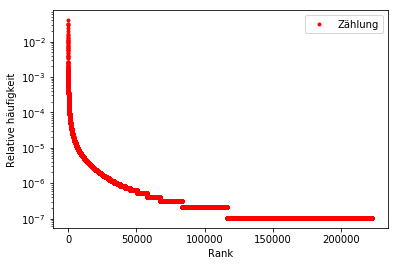

In [39]:
fig, ax = plt.subplots()
plt_rank = plt.plot(np.arange(len(rank)), rank, 'r.', label="Zählung")
#plt_zipf_law = plt.plot([0, len(rank)], [rank[0], rank[-1]], label="Zipf law")
plt.xlabel('Rank')
plt.ylabel('Relative häufigkeit')
plt.legend(["Zählung", "Zipf law"])
ax.set_yscale("log", nonposy='clip')

# 2) Bag of Words

In [40]:
#bag_of_words = np.zeros((len(people['text']), len(word_index)))
bag_of_words = lil_matrix((len(people['text']), len(word_index)))
print(bag_of_words.shape)

for i, text in enumerate(people['text']):
    for word in nltk.word_tokenize(str(text.encode('utf8'))):
        if not word.isalpha(): continue
        w = stem.stem(word.lower())
        idx = word_index[w]
        bag_of_words[i, idx] = 1

(10000, 222679)


In [4]:
def cos_dist(a:np.ndarray, b:np.ndarray):
    return np.dot(a,b)/(np.linalg.norm(a) * np.linalg.norm(b))

def scalar(a:np.ndarray, b:np.ndarray):
    return np.dot(a,b)

def bow_similarity(id:int, bow, use_cos_dist=False):
    sims = []
    for i in range(bow.shape[0]):
        if i == id: continue
        a = bow[id,:].toarray().flatten()
        b = bow[i, :].toarray().flatten()
        if use_cos_dist:
            sims.append((i, cos_dist(a, b)))
        else:
            sims.append((i, scalar(a, b)))
                    
    return list(sorted(sims, key=lambda sim: sim[1], reverse=True))

In [5]:
def print_best_10(id, bow, use_cos_dist=False, with_text=True):
    for sim in bow_similarity(id, bag_of_words, use_cos_dist=use_cos_dist)[:10]:
        idx = sim[0]
        print(people['Name'][idx])
        if with_text:
            print(people['text'][idx][:400])
        print(f"similarity: {sim[1]}")
        print()

### Schumacher

In [54]:
# 3 Schumacher
print_best_10(3, bag_of_words, use_cos_dist=False)

Wallenstein
Wallenstein, eigentlich Albrecht Wenzel Eusebius von Waldstein, tschechisch Albrecht Václav Eusebius z Valdštejna (* 24. September 1583 in Hermanitz an der Elbe, Böhmen; † 25. Februar 1634 in Eger, Böhmen), war ein böhmischer Feldherr und Politiker. Er war Herzog von Friedland und Sagan, von 1628 bis 1631 als Albrecht VIII. Herzog zu Mecklenburg, Fürst zu Wenden, Graf von Schwerin, Herr von Rostoc
similarity: 670.0

Theobald von Bethmann Hollweg
Theobald Theodor Friedrich Alfred von Bethmann Hollweg (* 29. November 1856 in Hohenfinow, Provinz Brandenburg; † 2. Januar 1921 ebenda) war ein deutscher Politiker in der Zeit des Kaiserreichs. Seine Karriere begann als Verwaltungsbeamter und gipfelte in der Amtszeit als Reichskanzler von 1909 bis 1917. Theobald von Bethmann Hollweg vertrat liberale Auffassungen und stand der Fortschrittlichen Vo
similarity: 640.0

Benjamin Franklin
Benjamin Franklin (* 17. Januar 1706 in Boston, Massachusetts; † 17. April 1790 in Philadelphia, Pen

## Einstein

In [55]:
# 215 Einstein
print_best_10(215, bag_of_words, use_cos_dist=False)

Benjamin Franklin
Benjamin Franklin (* 17. Januar 1706 in Boston, Massachusetts; † 17. April 1790 in Philadelphia, Pennsylvania) war ein amerikanischer Drucker, Verleger, Schriftsteller, Naturwissenschaftler, Erfinder und Staatsmann. Als einer der Gründerväter der Vereinigten Staaten beteiligte er sich am Entwurf der Unabhängigkeitserklärung der Vereinigten Staaten und war einer ihrer Unterzeichner. Während der Ame
similarity: 507.0

Theobald von Bethmann Hollweg
Theobald Theodor Friedrich Alfred von Bethmann Hollweg (* 29. November 1856 in Hohenfinow, Provinz Brandenburg; † 2. Januar 1921 ebenda) war ein deutscher Politiker in der Zeit des Kaiserreichs. Seine Karriere begann als Verwaltungsbeamter und gipfelte in der Amtszeit als Reichskanzler von 1909 bis 1917. Theobald von Bethmann Hollweg vertrat liberale Auffassungen und stand der Fortschrittlichen Vo
similarity: 506.0

Wallenstein
Wallenstein, eigentlich Albrecht Wenzel Eusebius von Waldstein, tschechisch Albrecht Václav Eusebius

## Jackson

In [56]:
# 1951 Jackson
print_best_10(1951, bag_of_words, use_cos_dist=False)

Mahatma Gandhi
Mohandas Karamchand Gandhi (Gujarati: મોહનદાસ કરમચંદ ગાંધી, Hindi: मोहनदास करमचंद गांधी Mohandās Karamchand Gāndhī; genannt Mahatma Gandhi; * 2. Oktober 1869 in Porbandar, Gujarat; † 30. Januar 1948 in Neu-Delhi, Delhi) war ein indischer Rechtsanwalt, Widerstandskämpfer, Revolutionär, Publizist, Morallehrer, Asket und Pazifist. Zu Beginn des 20. Jahrhunderts setzte sich Gandhi in Südafrika gegen d
similarity: 286.0

Mohandas Karamchand Gandhi
Mohandas Karamchand Gandhi (Gujarati: મોહનદાસ કરમચંદ ગાંધી, Hindi: मोहनदास करमचंद गांधी Mohandās Karamchand Gāndhī; genannt Mahatma Gandhi; * 2. Oktober 1869 in Porbandar, Gujarat; † 30. Januar 1948 in Neu-Delhi, Delhi) war ein indischer Rechtsanwalt, Widerstandskämpfer, Revolutionär, Publizist, Morallehrer, Asket und Pazifist. Zu Beginn des 20. Jahrhunderts setzte sich Gandhi in Südafrika gegen d
similarity: 286.0

Marlon Brando
Marlon Brando, Jr. (* 3. April 1924 in Omaha, Nebraska; † 1. Juli 2004 in Los Angeles, Kalifornien) war 

# 3) Bag of Words without stop words

In [15]:
stopwords = set()
with open("GermanST.txt", "r") as f:
    stopwords = set(f.readlines())

In [46]:
word_count = 0
word_index_ws = {}

i = 0
for text in people['text']:
    for word in nltk.word_tokenize(str(text.encode('utf8'))):
        if not word.isalpha(): continue
        w = stem.stem(word.lower())
        if w in stopwords : continue
        word_dict[w] += 1
        word_count += 1
        if w not in word_index_ws:
            word_index_ws[w] = i
            i += 1

In [47]:
bag_of_words_ws = lil_matrix((len(people['text']), len(word_index_ws)))
print(bag_of_words_ws.shape)

for i, text in enumerate(people['text']):
    for word in nltk.word_tokenize(str(text.encode('utf8'))):
        if not word.isalpha(): continue
        w = stem.stem(word.lower())
        if w in stopwords : continue
        idx = word_index_ws[w]
        bag_of_words_ws[i, idx] = 1

(10000, 222679)


## Schumacher

In [57]:
# 3 Schumacher
print_best_10(3, bag_of_words_ws, use_cos_dist=False)

Wallenstein
Wallenstein, eigentlich Albrecht Wenzel Eusebius von Waldstein, tschechisch Albrecht Václav Eusebius z Valdštejna (* 24. September 1583 in Hermanitz an der Elbe, Böhmen; † 25. Februar 1634 in Eger, Böhmen), war ein böhmischer Feldherr und Politiker. Er war Herzog von Friedland und Sagan, von 1628 bis 1631 als Albrecht VIII. Herzog zu Mecklenburg, Fürst zu Wenden, Graf von Schwerin, Herr von Rostoc
similarity: 670.0

Theobald von Bethmann Hollweg
Theobald Theodor Friedrich Alfred von Bethmann Hollweg (* 29. November 1856 in Hohenfinow, Provinz Brandenburg; † 2. Januar 1921 ebenda) war ein deutscher Politiker in der Zeit des Kaiserreichs. Seine Karriere begann als Verwaltungsbeamter und gipfelte in der Amtszeit als Reichskanzler von 1909 bis 1917. Theobald von Bethmann Hollweg vertrat liberale Auffassungen und stand der Fortschrittlichen Vo
similarity: 640.0

Benjamin Franklin
Benjamin Franklin (* 17. Januar 1706 in Boston, Massachusetts; † 17. April 1790 in Philadelphia, Pen

## Einstein

In [49]:
# 215 Einstein
print_best_10(215, bag_of_words_ws, use_cos_dist=False)

Benjamin Franklin
Benjamin Franklin (* 17. Januar 1706 in Boston, Massachusetts; † 17. April 1790 in Philadelphia, Pennsylvania) war ein amerikanischer Drucker, Verleger, Schriftsteller, Naturwissenschaftler, Erfinder und Staatsmann. Als einer der Gründerväter der Vereinigten Staaten beteiligte er sich am Entwurf der Unabhängigkeitserklärung der Vereinigten Staaten und war einer ihrer Unterzeichner. Während der Amerikanischen Revolution vertrat er die Vereinigten Staaten als Diplomat in Frankreich und handelte sowohl den Allianzvertrag mit den Franzosen als auch den Frieden von Paris aus, der den Amerikanischen
similarity: 507.0

Theobald von Bethmann Hollweg
Theobald Theodor Friedrich Alfred von Bethmann Hollweg (* 29. November 1856 in Hohenfinow, Provinz Brandenburg; † 2. Januar 1921 ebenda) war ein deutscher Politiker in der Zeit des Kaiserreichs. Seine Karriere begann als Verwaltungsbeamter und gipfelte in der Amtszeit als Reichskanzler von 1909 bis 1917. Theobald von Bethmann Holl

## Jackson

In [58]:
# 1951 Jackson
print_best_10(1951, bag_of_words_ws, use_cos_dist=False)

Mahatma Gandhi
Mohandas Karamchand Gandhi (Gujarati: મોહનદાસ કરમચંદ ગાંધી, Hindi: मोहनदास करमचंद गांधी Mohandās Karamchand Gāndhī; genannt Mahatma Gandhi; * 2. Oktober 1869 in Porbandar, Gujarat; † 30. Januar 1948 in Neu-Delhi, Delhi) war ein indischer Rechtsanwalt, Widerstandskämpfer, Revolutionär, Publizist, Morallehrer, Asket und Pazifist. Zu Beginn des 20. Jahrhunderts setzte sich Gandhi in Südafrika gegen d
similarity: 286.0

Mohandas Karamchand Gandhi
Mohandas Karamchand Gandhi (Gujarati: મોહનદાસ કરમચંદ ગાંધી, Hindi: मोहनदास करमचंद गांधी Mohandās Karamchand Gāndhī; genannt Mahatma Gandhi; * 2. Oktober 1869 in Porbandar, Gujarat; † 30. Januar 1948 in Neu-Delhi, Delhi) war ein indischer Rechtsanwalt, Widerstandskämpfer, Revolutionär, Publizist, Morallehrer, Asket und Pazifist. Zu Beginn des 20. Jahrhunderts setzte sich Gandhi in Südafrika gegen d
similarity: 286.0

Marlon Brando
Marlon Brando, Jr. (* 3. April 1924 in Omaha, Nebraska; † 1. Juli 2004 in Los Angeles, Kalifornien) war 

# 4a) Term frequency without stop words

In [7]:
def tf_idf(use_stopword=False, do_stem=False, idf=False):
    word_dict = defaultdict(int)
    word_count = 0
    word_index = {}
    num_docs = people.shape[0]
    idf_dict = defaultdict(int)

    i = 0
    for text in people['text']:
        ws = set()
        for word in nltk.word_tokenize(str(text.encode('utf8'))):
            if not word.isalpha(): continue
            if stem:
                word = stem.stem(word.lower())
            if use_stopword and word in stopwords: continue
            word_dict[word] += 1
            word_count += 1
            if word not in ws:
                ws.add(word)
            if word not in word_index:
                word_index[word] = i
                i += 1
                
        for w in ws:
            idf_dict[w] += 1
    
    tfidf = lil_matrix((len(people['text']), len(word_index)))
    print(tfidf.shape)

    for i, text in enumerate(people['text']):
        for word in nltk.word_tokenize(str(text.encode('utf8'))):
            if not word.isalpha(): continue
            if do_stem:
                word = stem.stem(word.lower())
            if use_stopword and word in stopwords: continue
            idx = word_index[word]
            if idf:
                tfidf[i, idx] = word_dict[word] * (1 + math.log(num_docs/idf_dict[word]))
            else:
                tfidf[i, idx] = word_dict[word]
    return tfidf

In [ ]:
tfidf_ws = tf_idf(use_stopword=False, do_stem=False)

# 3 Schumacher
print("Schumacher")
print_best_10(3, bag_of_words_ws, use_cos_dist=False, with_text=False)
print()

# 215 Einstein
print("Einstein")
print_best_10(215, bag_of_words_ws, use_cos_dist=False, with_text=False)
print()

# 1951 Jackson
print("Jackson")
print_best_10(1951, bag_of_words_ws, use_cos_dist=False, with_text=False)

# 4b) Term frequency without stop words and with stemming

In [70]:
tfidf_ws = tf_idf(use_stopword=False, do_stem=True)

# 3 Schumacher
print("Schumacher")
print_best_10(3, tfidf_ws, use_cos_dist=False, with_text=False)
print()

# 215 Einstein
print("Einstein")
print_best_10(215, tfidf_ws, use_cos_dist=False, with_text=False)
print()

# 1951 Jackson
print("Jackson")
print_best_10(1951, tfidf_ws, use_cos_dist=False, with_text=False)

(10000, 222679)
Schumacher
Wallenstein
similarity: 670.0

Theobald von Bethmann Hollweg
similarity: 640.0

Benjamin Franklin
similarity: 627.0

Herbert C. Hoover
similarity: 595.0

Herbert Hoover
similarity: 595.0

Florence Nightingale
similarity: 593.0

George Washington
similarity: 586.0

Fernando Alonso
similarity: 578.0

Marlon Brando
similarity: 573.0

Mahatma Gandhi
similarity: 573.0


Einstein
Benjamin Franklin
similarity: 507.0

Theobald von Bethmann Hollweg
similarity: 506.0

Wallenstein
similarity: 488.0

Max Liebermann
similarity: 487.0

Florence Nightingale
similarity: 486.0

Franz Wilhelm Junghuhn
similarity: 475.0

Herbert C. Hoover
similarity: 470.0

Herbert Hoover
similarity: 470.0

Mahatma Gandhi
similarity: 466.0

Mohandas Karamchand Gandhi
similarity: 466.0


Jackson
Mahatma Gandhi
similarity: 286.0

Mohandas Karamchand Gandhi
similarity: 286.0

Marlon Brando
similarity: 283.0

Wallenstein
similarity: 276.0

Michael Schumacher
similarity: 276.0

Benjamin Franklin
sim

# 4c) Term frequency, stopped, stemmed and Cosine Similarity

In [72]:
tfidf_ss = tf_idf(use_stopword=True, do_stem=True)

(10000, 222679)
Schumacher
Wallenstein
similarity: 670.0

Theobald von Bethmann Hollweg
similarity: 640.0

Benjamin Franklin
similarity: 627.0

Herbert C. Hoover
similarity: 595.0

Herbert Hoover
similarity: 595.0

Florence Nightingale
similarity: 593.0

George Washington
similarity: 586.0

Fernando Alonso
similarity: 578.0

Marlon Brando
similarity: 573.0

Mahatma Gandhi
similarity: 573.0


Einstein
Benjamin Franklin
similarity: 507.0

Theobald von Bethmann Hollweg
similarity: 506.0

Wallenstein
similarity: 488.0

Max Liebermann
similarity: 487.0

Florence Nightingale
similarity: 486.0

Franz Wilhelm Junghuhn
similarity: 475.0

Herbert C. Hoover
similarity: 470.0

Herbert Hoover
similarity: 470.0

Mahatma Gandhi
similarity: 466.0

Mohandas Karamchand Gandhi
similarity: 466.0


Jackson
Mahatma Gandhi
similarity: 286.0

Mohandas Karamchand Gandhi
similarity: 286.0

Marlon Brando
similarity: 283.0

Wallenstein
similarity: 276.0

Michael Schumacher
similarity: 276.0

Benjamin Franklin
sim

In [102]:
# 3 Schumacher
print("Schumacher")
print_best_10(3, tfidf_ss, use_cos_dist=True, with_text=False)
print()

# 215 Einstein
print("Einstein")
print_best_10(215, tfidf_ss, use_cos_dist=True, with_text=False)
print()

# 1951 Jackson
print("Jackson")
print_best_10(1951, tfidf_ss, use_cos_dist=True, with_text=False)

Schumacher
Fernando Alonso
similarity: 0.43259498462741586

Lewis Hamilton
similarity: 0.4232073155611383

Sebastian Vettel
similarity: 0.4125359134686056

Kimi Räikkönen
similarity: 0.40856511143695723

Rubens Barrichello
similarity: 0.398411126073899

Heinz-Harald Frentzen
similarity: 0.3771030394627472

Alain Prost
similarity: 0.37290592139973916

Jacques Villeneuve
similarity: 0.3726410297274071

Jenson Button
similarity: 0.3701953270703065

Ayrton Senna
similarity: 0.36559549849420114


Einstein
Max Planck
similarity: 0.3676940979460488

David Hilbert
similarity: 0.33990370886414417

Percy Ernst Schramm
similarity: 0.33788731616043205

Wolfgang Pauli
similarity: 0.33726860771514705

Otto Hahn
similarity: 0.33703622530055394

Karl Jaspers
similarity: 0.3332119048446101

Johannes Haller
similarity: 0.33083422944083657

Karl Hampe (Historiker)
similarity: 0.33023297820961706

Bertrand Russell
similarity: 0.32938081968297833

Max Frisch
similarity: 0.32827254428793357


Jackson
Eminem

# 5) TF-IDF

In [16]:
tfidf = tf_idf(use_stopword=True, do_stem=True, idf=True)

(10000, 222679)


In [101]:
# 3 Schumacher
print("Schumacher")
print_best_10(3, tfidf, use_cos_dist=True, with_text=False)
print()

# 215 Einstein
print("Einstein")
print_best_10(215, tfidf, use_cos_dist=True, with_text=False)
print()

# 1951 Jackson
print("Jackson")
print_best_10(1951, tfidf, use_cos_dist=True, with_text=False)

Schumacher
Fernando Alonso
similarity: 0.43259498462741586

Lewis Hamilton
similarity: 0.4232073155611383

Sebastian Vettel
similarity: 0.4125359134686056

Kimi Räikkönen
similarity: 0.40856511143695723

Rubens Barrichello
similarity: 0.398411126073899

Heinz-Harald Frentzen
similarity: 0.3771030394627472

Alain Prost
similarity: 0.37290592139973916

Jacques Villeneuve
similarity: 0.3726410297274071

Jenson Button
similarity: 0.3701953270703065

Ayrton Senna
similarity: 0.36559549849420114


Einstein
Max Planck
similarity: 0.3676940979460488

David Hilbert
similarity: 0.33990370886414417

Percy Ernst Schramm
similarity: 0.33788731616043205

Wolfgang Pauli
similarity: 0.33726860771514705

Otto Hahn
similarity: 0.33703622530055394

Karl Jaspers
similarity: 0.3332119048446101

Johannes Haller
similarity: 0.33083422944083657

Karl Hampe (Historiker)
similarity: 0.33023297820961706

Bertrand Russell
similarity: 0.32938081968297833

Max Frisch
similarity: 0.32827254428793357


Jackson
Eminem

# 6a) LSA with k=100

In [13]:
s, e, u = np.linalg.svd(tfidf.toarray())

NameError: name 'tfidf' is not defined

In [ ]:
epsilon = np.diag(e[:100])
#np.diag(a)

# 6b) LSA with k=500

# 6c) LSA with k=1000